In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("/netscratch2/jlautz/model_robustness/src/model_robustness/attacks/experimenting"), '..')))

In [13]:
df = pd.read_csv("../../data/all_results.csv")

In [3]:
df.head()

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc
0,0,NN_tune_trainable_a17ed_00710_710_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.0010,0.9,sgd,0.0001,674695,0.067,0.979,0.378464,0.3051
1,1,NN_tune_trainable_a17ed_00686_686_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,relu,0.0001,0.9,adam,0.0001,486815,0.054,0.984,0.056045,0.8454
2,2,NN_tune_trainable_a17ed_01002_1002_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0001,0.9,sgd,0.0001,162638,2.301,0.113,0.230108,0.1135
3,3,NN_tune_trainable_a17ed_00775_775_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0010,0.9,adam,0.0010,651635,0.134,0.960,0.296555,0.2168
4,4,NN_tune_trainable_a17ed_01098_1098_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0010,0.9,sgd,0.0010,361619,2.301,0.113,0.230111,0.1135


In [14]:
df = df[(df.dataset=="CIFAR10") & (df.attack=="PGD") & (df.eps==0.1)]

In [8]:
rand = df[df.setup=="hyp-10-r"]

In [15]:
fix = df[df.setup=="hyp-10-f"]

In [9]:
len(rand)

2560

In [10]:
rand_good = rand[rand.old_acc >= rand.old_acc.mean()]

In [11]:
len(rand_good)

1879

<Axes: ylabel='Count'>

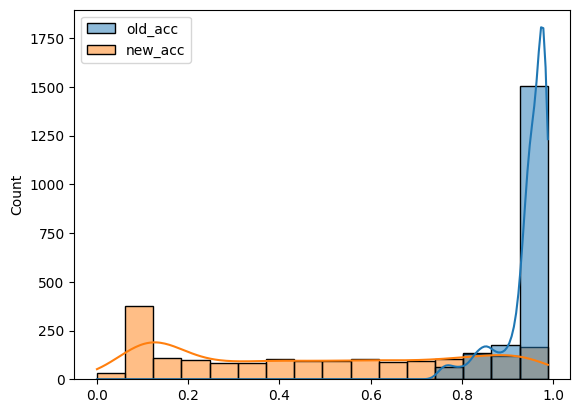

In [13]:
sns.histplot(rand_good[["old_acc", "new_acc"]], kde=True)

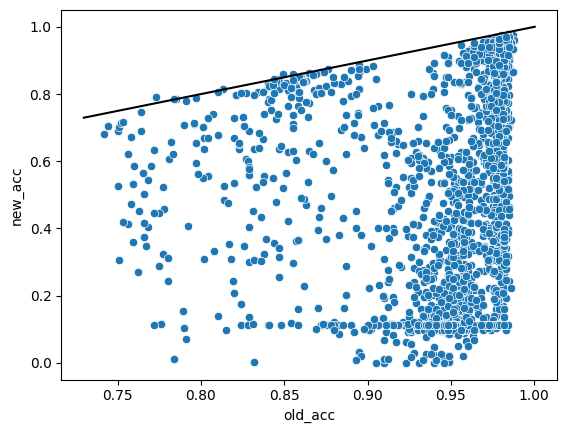

In [14]:
g = sns.scatterplot(rand_good, x="old_acc", y="new_acc")
# Draw a line of x=y 
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-k')
plt.show()

In [15]:
rand_good.head()

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc
0,0,NN_tune_trainable_a17ed_00710_710_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.0010,0.9,sgd,0.0001,674695,0.067,0.979,0.378464,0.3051
1,1,NN_tune_trainable_a17ed_00686_686_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,relu,0.0001,0.9,adam,0.0001,486815,0.054,0.984,0.056045,0.8454
3,3,NN_tune_trainable_a17ed_00775_775_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0010,0.9,adam,0.0010,651635,0.134,0.960,0.296555,0.2168
5,5,NN_tune_trainable_a17ed_00258_258_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,tanh,0.0010,0.9,adam,0.0010,851202,0.063,0.982,0.128391,0.5899
6,6,NN_tune_trainable_a17ed_02261_2261_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_uniform,sigmoid,0.0010,0.9,sgd,0.0001,859569,0.688,0.823,0.115500,0.6372


In [16]:
rand_good["delta"] = rand_good.old_acc - rand_good.new_acc

/tmp/ipykernel_86607/3452941515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_good["delta"] = rand_good.old_acc - rand_good.new_acc


In [17]:
rand_good

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc,delta
0,0,NN_tune_trainable_a17ed_00710_710_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.0010,0.9,sgd,0.0001,674695,0.067,0.979,0.378464,0.3051,0.6739
1,1,NN_tune_trainable_a17ed_00686_686_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,relu,0.0001,0.9,adam,0.0001,486815,0.054,0.984,0.056045,0.8454,0.1386
3,3,NN_tune_trainable_a17ed_00775_775_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0010,0.9,adam,0.0010,651635,0.134,0.960,0.296555,0.2168,0.7432
5,5,NN_tune_trainable_a17ed_00258_258_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,tanh,0.0010,0.9,adam,0.0010,851202,0.063,0.982,0.128391,0.5899,0.3921
6,6,NN_tune_trainable_a17ed_02261_2261_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_uniform,sigmoid,0.0010,0.9,sgd,0.0001,859569,0.688,0.823,0.115500,0.6372,0.1858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2552,NN_tune_trainable_a17ed_02548_2548_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_uniform,sigmoid,0.0001,0.9,sgd,0.0001,76505,0.536,0.867,0.063534,0.8582,0.0088
2553,2553,NN_tune_trainable_a17ed_02358_2358_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,sigmoid,0.0001,0.9,adam,0.0010,565166,0.159,0.964,0.040576,0.9094,0.0546
2554,2554,NN_tune_trainable_a17ed_00871_871_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0001,0.9,sgd,0.0010,174624,0.182,0.943,0.229795,0.5795,0.3635
2555,2555,NN_tune_trainable_a17ed_00162_162_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,tanh,0.0001,0.9,adam,0.0001,897406,0.701,0.766,0.182719,0.5037,0.2623


In [18]:
rand_good.delta.describe()

count    1879.000000
mean        0.461923
std         0.304170
min        -0.019600
25%         0.161500
50%         0.474500
75%         0.776150
max         0.947100
Name: delta, dtype: float64

In [19]:
a = rand_good[rand_good.delta >= 0.776150]
b = rand_good[rand_good.delta <= 0.161500]

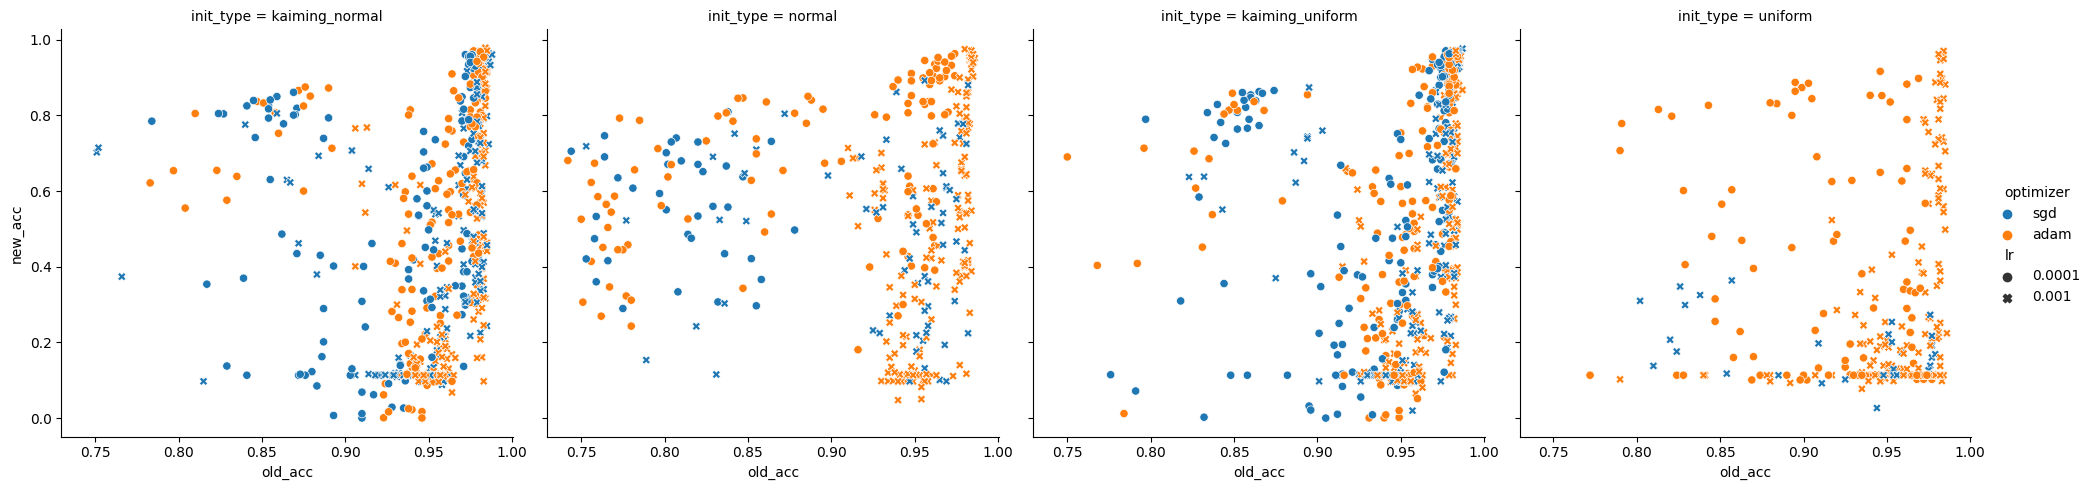

In [26]:
sns.color_palette("tab10")
g = sns.relplot(
    data=rand_good,
    x="old_acc",
    y="new_acc",
    hue="optimizer",
    style="lr",
    col="init_type",
    #palette="tab10"
)
# for i in range(len(g.axes[0])):
#     x0, x1 = g.axes[0][i].get_xlim()
#     y0, y1 = g.axes[0][i].get_ylim()
#     lims = [max(x0, y0), min(x1, y1)]
#     g.axes[0][i].plot(lims, lims, '-k')

plt.show()

In [27]:
rand.head()

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc
0,0,NN_tune_trainable_a17ed_00710_710_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.0010,0.9,sgd,0.0001,674695,0.067,0.979,0.378464,0.3051
1,1,NN_tune_trainable_a17ed_00686_686_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,relu,0.0001,0.9,adam,0.0001,486815,0.054,0.984,0.056045,0.8454
2,2,NN_tune_trainable_a17ed_01002_1002_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0001,0.9,sgd,0.0001,162638,2.301,0.113,0.230108,0.1135
3,3,NN_tune_trainable_a17ed_00775_775_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.5,kaiming_normal,tanh,0.0010,0.9,adam,0.0010,651635,0.134,0.960,0.296555,0.2168
4,4,NN_tune_trainable_a17ed_01098_1098_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,normal,relu,0.0010,0.9,sgd,0.0010,361619,2.301,0.113,0.230111,0.1135


In [29]:
rand[(rand.dropout==0.0) & (rand.init_type=="kaiming_normal") & (rand.nlin == "tanh") & (rand.lr == 0.001) & (rand.optimizer=="sgd") & (rand.wd == 0.001)]

,Unnamed: 0,name,dataset,attack,setup,eps,dropout,init_type,nlin,lr,momentum,optimizer,wd,seed,old_loss,old_acc,new_loss,new_acc
83,83,NN_tune_trainable_a17ed_00326_326_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,873861,0.062,0.982,0.129537,0.5327
347,347,NN_tune_trainable_a17ed_02374_2374_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,47723,0.063,0.982,0.106317,0.6791
810,810,NN_tune_trainable_a17ed_00838_838_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,560207,0.063,0.981,0.071442,0.7462
811,811,NN_tune_trainable_a17ed_01862_1862_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,20345,0.054,0.985,0.304168,0.2434
1390,1390,NN_tune_trainable_a17ed_02118_2118_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,259440,0.062,0.982,0.143243,0.5944
1432,1432,NN_tune_trainable_a17ed_01606_1606_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,802037,0.058,0.983,0.163278,0.4884
1910,1910,NN_tune_trainable_a17ed_00070_70_model::dropou...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,115550,0.061,0.981,0.200004,0.3620
2228,2228,NN_tune_trainable_a17ed_01094_1094_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,961808,0.059,0.983,0.203742,0.4126
2331,2331,NN_tune_trainable_a17ed_01350_1350_model::drop...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,998606,0.064,0.980,0.220310,0.3812
2409,2409,NN_tune_trainable_a17ed_00582_582_model::dropo...,MNIST,PGD,hyp-10-r,0.1,0.0,kaiming_normal,tanh,0.001,0.9,sgd,0.001,954276,0.065,0.982,0.114256,0.6130


In [16]:
c = fix[(fix.dropout==0.0) & (fix.init_type=="kaiming_normal") & (fix.nlin == "tanh") & (fix.lr == 0.001) & (fix.optimizer=="sgd") & (fix.wd == 0.001)].sort_values(by="seed")
model_paths = list(c.name)

In [17]:
# Check the performances of those models over earlier epochs
df = pd.DataFrame(columns=[i for i in range(10)])
epochs_iter = [-41, -31, -21, -11, -1]
epochs_df = [i for i in range(10)]
root_path = Path("/ds2/model_zoos/zoos_v2/CIFAR10/large/tune_zoo_cifar10_large_hyperparameter_10_fixed_seeds")
for j, path in enumerate(model_paths):

    for i, line in enumerate(open(os.path.join(root_path, path, "result.json"), 'r')):
        aux_dic = json.loads(line)
        df.loc[j, i] = aux_dic["test_acc"]
#         if i == 10:
#             aux_dic = json.loads(line)
#             df.loc[j, "epoch_10"] = aux_dic["test_acc"]
#         elif i == 20:
#             aux_dic = json.loads(line)
#             df.loc[j, "epoch_20"] = aux_dic["test_acc"]
#         elif i == 30:
#             aux_dic = json.loads(line)
#             df.loc[j, "epoch_30"] = aux_dic["test_acc"]
#         elif i==40:
#             aux_dic = json.loads(line)
#             df.loc[j, "epoch_40"] = aux_dic["test_acc"]
#         elif i == 50:
#             aux_dic = json.loads(line)
#             df.loc[j, "epoch_50"] = aux_dic["test_acc"]

In [18]:
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.1285,0.4308,0.5157,0.5285,0.5668,0.5837,0.6042,0.6069,0.6139,0.6187,...,0.6470,0.6590,0.6594,0.6575,0.6631,0.6501,0.6537,0.6615,0.6534,0.6561
1,0.0909,0.4314,0.5276,0.5296,0.5802,0.5752,0.5933,0.5949,0.6115,0.6124,...,0.6479,0.6496,0.6461,0.6582,0.6625,0.6543,0.6587,0.6567,0.6535,0.6605
2,0.0752,0.4524,0.5242,0.5437,0.5718,0.5794,0.6097,0.5958,0.6105,0.6186,...,0.6464,0.6699,0.6642,0.6662,0.6601,0.6463,0.6508,0.6694,0.6608,0.6686
3,0.1287,0.4448,0.5336,0.5412,0.5698,0.5847,0.5931,0.6034,0.6202,0.5851,...,0.6282,0.6438,0.6528,0.6610,0.6583,0.6474,0.6554,0.6610,0.6425,0.6549
4,0.0853,0.4314,0.5171,0.511,0.5567,0.5578,0.586,0.588,0.6083,0.5974,...,0.6228,0.6445,0.6499,0.6511,0.6568,0.6460,0.6475,0.6580,0.6448,0.6462
5,0.121,0.4272,0.5269,0.5388,0.5743,0.5719,0.5913,0.6067,0.6232,0.6086,...,0.6493,0.6606,0.6485,0.6549,0.6651,0.6459,0.6589,0.6481,0.6566,0.6557
6,0.1131,0.4355,0.5234,0.5336,0.5752,0.575,0.5919,0.5978,0.6157,0.611,...,0.6419,0.6457,0.6518,0.6528,0.6559,0.6379,0.6454,0.6574,0.6498,0.6559
7,0.1302,0.4649,0.532,0.5461,0.5795,0.5918,0.6083,0.6045,0.6129,0.6178,...,0.6524,0.6585,0.6460,0.6591,0.6634,0.6401,0.6503,0.6590,0.6470,0.6613
8,0.0739,0.4455,0.5301,0.5386,0.5698,0.5839,0.6005,0.5921,0.6256,0.6148,...,0.6478,0.6532,0.6495,0.6588,0.6557,0.6572,0.6579,0.6644,0.6453,0.6684
9,0.1151,0.4496,0.514,0.5408,0.5571,0.5796,0.6003,0.6015,0.6247,0.6146,...,0.6458,0.6604,0.6573,0.6582,0.6650,0.6524,0.6585,0.6621,0.6507,0.6558


In [10]:
# Check the performances of those models over earlier epochs
df = pd.DataFrame(columns=[i for i in range(10)])
epochs_iter = [-41, -31, -21, -11, -1]
epochs_df = [i for i in range(10)]
root_path = Path("/ds2/model_zoos/zoos_v2/SVHN/tune_zoo_svhn_hyperparameter_10_fixed_seeds")
for j, path in enumerate(model_paths):

    for i, line in enumerate(open(os.path.join(root_path, path, "result.json"), 'r')):
        aux_dic = json.loads(line)
        df.loc[j, i] = aux_dic["test_acc"]

In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.094345,0.655731,0.734289,0.755224,0.767133,0.779348,0.772703,0.784995,0.780155,0.798786,...,0.817033,0.809849,0.812884,0.819107,0.822910,0.816879,0.813537,0.822603,0.816111,0.817263
1,0.105293,0.680662,0.751191,0.764943,0.779963,0.784189,0.790143,0.790297,0.793715,0.795175,...,0.822372,0.813614,0.808121,0.817763,0.823525,0.813844,0.806315,0.817840,0.816572,0.816956
2,0.108405,0.666987,0.742279,0.772165,0.774739,0.794484,0.785418,0.788722,0.780501,0.77908,...,0.819607,0.805509,0.808044,0.819222,0.812308,0.811463,0.811079,0.806123,0.809312,0.798556
3,0.099109,0.700983,0.744584,0.764444,0.763906,0.785572,0.780847,0.784765,0.778465,0.789605,...,0.816610,0.813038,0.818032,0.819876,0.816495,0.812577,0.810118,0.818915,0.817110,0.811809
4,0.076252,0.644668,0.72553,0.75,0.749155,0.77616,0.770321,0.777351,0.774624,0.784995,...,0.818224,0.813268,0.817071,0.823486,0.823141,0.819146,0.799285,0.816380,0.821796,0.821835
5,0.100492,0.673056,0.733367,0.755954,0.762446,0.779809,0.787147,0.786762,0.791334,0.799708,...,0.830132,0.826713,0.825023,0.828903,0.826944,0.831630,0.825983,0.833205,0.829479,0.824063
6,0.081054,0.680585,0.747196,0.749501,0.757683,0.780386,0.766902,0.779694,0.785034,0.790373,...,0.818108,0.818224,0.814766,0.816111,0.807660,0.820529,0.808851,0.814728,0.812884,0.811578
7,0.092348,0.693569,0.747772,0.763637,0.766518,0.79264,0.790565,0.788222,0.790066,0.800361,...,0.817724,0.817110,0.815151,0.819491,0.822219,0.815957,0.813460,0.817648,0.822296,0.817532
8,0.077443,0.663952,0.72092,0.753918,0.744046,0.774355,0.771935,0.784534,0.789375,0.799862,...,0.814344,0.818915,0.815227,0.815496,0.815112,0.813191,0.806085,0.822641,0.822372,0.815112
9,0.097457,0.654425,0.73644,0.750768,0.760487,0.781999,0.783536,0.773625,0.778119,0.797288,...,0.816841,0.814651,0.808121,0.815458,0.820797,0.815074,0.810579,0.814766,0.813883,0.814536
